# Лабораторная работа: Сверточные нейронные сети (CNN) с PyTorch

## Задание
Реализация и анализ сверточной нейронной сети для классификации изображений на наборе данных CIFAR-10 с использованием PyTorch.


## 1. Загрузка и подготовка данных


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 12

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Используемое устройство: {device}')


Используемое устройство: cpu


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

classes = ('самолет', 'автомобиль', 'птица', 'кошка', 'олень',
           'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик')

print(f'Размер тренировочного набора: {len(trainset)}')
print(f'Размер тестового набора: {len(testset)}')
print(f'Количество классов: {len(classes)}')


Размер тренировочного набора: 50000
Размер тестового набора: 10000
Количество классов: 10


Примеры изображений:


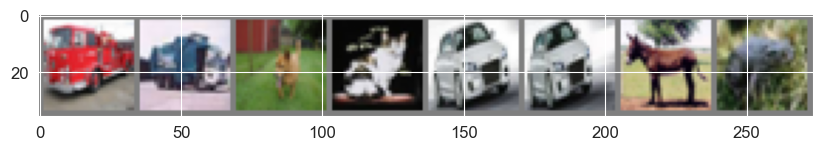

Метки: грузовик грузовик собака кошка автомобиль автомобиль лошадь лягушка


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

print('Примеры изображений:')
imshow(torchvision.utils.make_grid(images[:8]))
print('Метки:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))


## 2. Определение архитектуры CNN


In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Слой 1: Извлекает простые признаки (линии, углы)
        # 3  - входные каналы (RGB картинка)
        # 32 - выходные каналы (количество фильтров, которые мы обучаем)
        # 3  - размер ядра фильтра (окно 3x3 пикселя)
        # padding=1 - добавляет рамку из нулей вокруг картинки, чтобы размер не уменьшался после свертки
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)

        # Сжимает картинку в 2 раза, выбирая максимум из квадрата 2x2
        # 2 - размер окна (kernel_size)
        # 2 - шаг (stride), на сколько пикселей сдвигается окно
        self.pool1 = nn.MaxPool2d(2, 2)

        # Случайно отключает 25% нейронов, чтобы сеть не запоминала шум
        self.dropout1 = nn.Dropout(0.25)

        # Слой 2: Извлекает более сложные признаки
        # 32 - вход (должен совпадать с выходом conv1)
        # 64 - выход (увеличиваем число фильтров, чтобы найти больше деталей)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2) # Сжимает еще в 2 раза
        self.dropout2 = nn.Dropout(0.25)

        # Слой 3: Извлекает высокоуровневые признаки (части объектов)
        # 64 - вход (от conv2)
        # 128 - выход
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2) # Сжимает еще в 2 раза (итоговый размер карты признаков 4x4)
        self.dropout3 = nn.Dropout(0.25)

        # Полносвязный слой: Классификация на основе признаков
        # Вход: 128 каналов * 4 высота * 4 ширина (размер после всех пулингов)
        # Выход: 256 нейронов (скрытый слой)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)

        # Отключаем 50% нейронов (стандарт для полносвязных слоев)
        self.dropout4 = nn.Dropout(0.5)

        # Финальный слой
        # Вход: 256 (от fc1)
        # Выход: 10 (количество классов в CIFAR-10)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # F.relu - Активация: убирает отрицательные значения, добавляет нелинейность

        # Блок 1: Свертка -> Активация -> Сжатие -> Регуляризация
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Блок 2
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Блок 3
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Выпрямление (Flatten): превращаем многомерный массив в вектор
        # -1 : "посчитай сам" (размер батча)
        # 128*4*4 : общее количество признаков
        x = x.view(-1, 128 * 4 * 4)

        # Классификация
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x) # Возвращает сырые оценки классов (logits)
        return x

model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


## 3. Обучение модели

**Оптимизированная версия для быстрого обучения:**
- Упрощенная архитектура (меньше слоев)
- Увеличенный batch size (256)
- Меньше эпох (5 для базовой, 3 для улучшенной)
- Убраны BatchNormalization слои для ускорения


In [6]:
# "Судья". Функция потерь.
# Она сравнивает ответ сети (output) с правильным ответом (target).
# Для классификации (где 1 верный класс из N) стандарт — CrossEntropyLoss.
criterion = nn.CrossEntropyLoss()

# "Механик". Оптимизатор Adam.
# Он берет ошибку, которую посчитал судья, и подкручивает веса сети, чтобы ошибка стала меньше.
# lr=0.001 (learning rate) — размер шага. Насколько сильно мы крутим веса за раз.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# "Умный помощник". Планировщик скорости обучения.
# Если сеть перестала улучшаться (loss вышел на плато), он уменьшает learning rate.
# factor=0.5 — уменьшить шаг в 2 раза.
# patience=3 — подождать 3 эпохи перед тем, как уменьшать.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

def train_epoch():
    # ПЕРЕКЛЮЧАТЕЛЬ РЕЖИМА: Включает Dropout и BatchNormalization.
    # Сеть знает, что сейчас она учится, поэтому "выключает" часть нейронов (Dropout).
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    # Цикл по батчам (кусочкам данных). Например, берем по 64 картинки.
    for batch_idx, (data, target) in enumerate(trainloader):
        # Отправляем данные на видеокарту (если есть)
        data, target = data.to(device), target.to(device)

        # --- ГЛАВНЫЙ ЦИКЛ ОБУЧЕНИЯ (4 шага) ---

        # 1. Обнуляем градиенты.
        # Если этого не сделать, старые ошибки смешаются с новыми. Нужно делать перед каждым шагом!
        optimizer.zero_grad()

        # 2. Прямой проход (Forward pass).
        # Сеть делает предсказание для текущих картинок.
        output = model(data)

        # 3. Расчет ошибки (Loss).
        # Сравниваем предсказание (output) с реальностью (target).
        loss = criterion(output, target)

        # 4. Обратное распространение (Backpropagation).
        # Вычисляем, какой вклад каждый нейрон внес в ошибку (ищем виноватых).
        loss.backward()

        # 5. Шаг оптимизатора.
        # Обновляем веса на основе найденных "виновных".
        optimizer.step()

        # --- СБОР СТАТИСТИКИ ---
        running_loss += loss.item()

        # Кто победил? Находим индекс нейрона с самым большим значением.
        # predicted — это предсказанные классы.
        _, predicted = torch.max(output.data, 1)

        total += target.size(0) # Сколько всего картинок в батче
        correct += (predicted == target).sum().item() # Сколько угадали верно

        # Просто выводим прогресс каждые 100 батчей, чтобы не скучать
        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}, Loss: {loss.item():.4f}')

    # Считаем среднюю ошибку и точность за всю эпоху
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate():
    # ПЕРЕКЛЮЧАТЕЛЬ РЕЖИМА: Выключает Dropout!
    # На экзамене (валидации) сеть должна работать на полную мощность, ничего выключать нельзя.
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    # ЭКОНОМИЯ ПАМЯТИ:
    # torch.no_grad() говорит PyTorch'у: "Не запоминай градиенты, мы сейчас не учимся".
    # Это ускоряет работу и экономит память видеокарты.
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)

            # Только предсказание и расчет ошибки.
            # Никакого backward() и optimizer.step() здесь нет!
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    epoch_loss = running_loss / len(testloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


In [7]:
num_epochs = 5
best_val_loss = float('inf')
patience = 3
patience_counter = 0

print("Начинаем обучение...")
for epoch in range(num_epochs):
    print(f'\nЭпоха {epoch+1}/{num_epochs}')
    
    train_loss, train_acc = train_epoch()
    val_loss, val_acc = validate()
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    scheduler.step(val_loss)
    
    print(f'Тренировочная точность: {train_acc:.2f}%, Потери: {train_loss:.4f}')
    print(f'Валидационная точность: {val_acc:.2f}%, Потери: {val_loss:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f'Early stopping на эпохе {epoch+1}')
        break

print('Обучение завершено!')


Начинаем обучение...

Эпоха 1/5
Batch 0, Loss: 2.3002
Batch 100, Loss: 1.5946
Тренировочная точность: 36.84%, Потери: 1.7121
Валидационная точность: 50.84%, Потери: 1.3612

Эпоха 2/5
Batch 0, Loss: 1.4351
Batch 100, Loss: 1.3767
Тренировочная точность: 50.77%, Потери: 1.3582
Валидационная точность: 57.83%, Потери: 1.1838

Эпоха 3/5
Batch 0, Loss: 1.1720
Batch 100, Loss: 1.0736
Тренировочная точность: 55.83%, Потери: 1.2219
Валидационная точность: 62.23%, Потери: 1.0716

Эпоха 4/5
Batch 0, Loss: 1.0628
Batch 100, Loss: 1.1772
Тренировочная точность: 59.74%, Потери: 1.1326
Валидационная точность: 64.64%, Потери: 1.0009

Эпоха 5/5
Batch 0, Loss: 1.0599
Batch 100, Loss: 1.1666
Тренировочная точность: 62.44%, Потери: 1.0527
Валидационная точность: 67.92%, Потери: 0.9150
Обучение завершено!


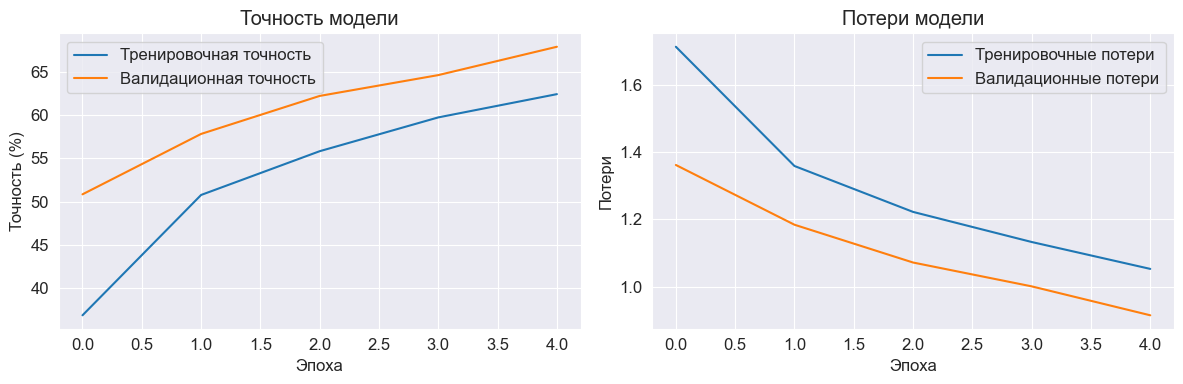

In [8]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Тренировочная точность')
plt.plot(val_accuracies, label='Валидационная точность')
plt.title('Точность модели')
plt.xlabel('Эпоха')
plt.ylabel('Точность (%)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Тренировочные потери')
plt.plot(val_losses, label='Валидационные потери')
plt.title('Потери модели')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()

plt.tight_layout()
plt.show()


## 4. Оценка модели


In [9]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_preds = []
all_labels = []
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for data, target in testloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        
        test_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

test_accuracy = 100. * correct / total
test_loss = test_loss / len(testloader)

print(f'Точность на тестовом наборе: {test_accuracy:.2f}%')
print(f'Потери на тестовом наборе: {test_loss:.4f}')


Точность на тестовом наборе: 67.92%
Потери на тестовом наборе: 0.9150


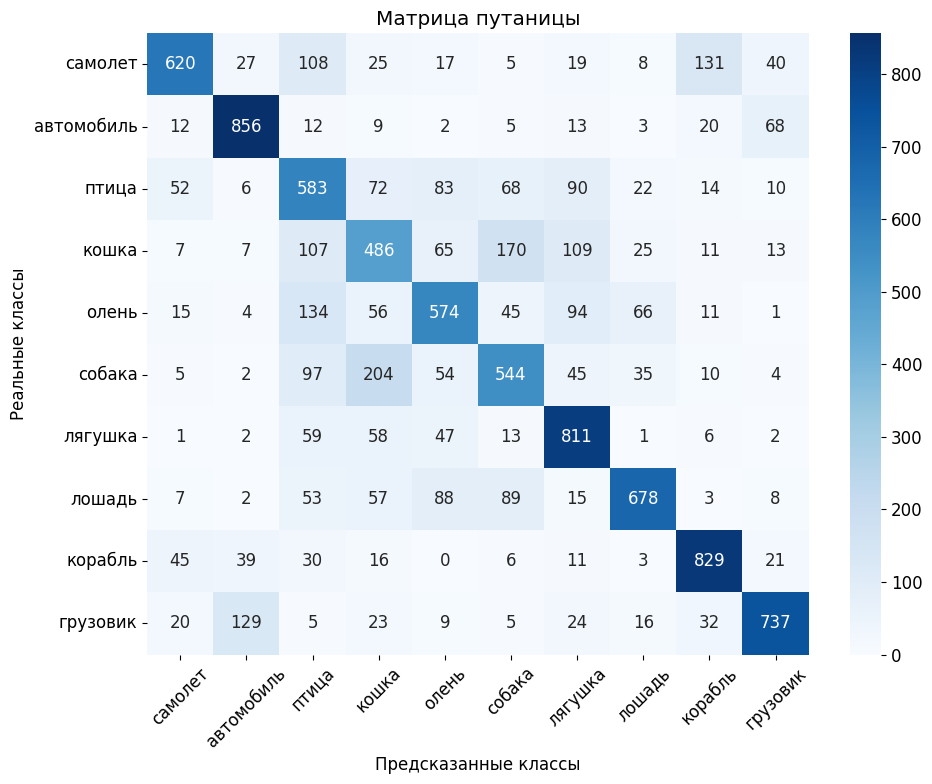


Отчет о классификации:
              precision    recall  f1-score   support

     самолет       0.79      0.62      0.70      1000
  автомобиль       0.80      0.86      0.83      1000
       птица       0.49      0.58      0.53      1000
       кошка       0.48      0.49      0.48      1000
       олень       0.61      0.57      0.59      1000
      собака       0.57      0.54      0.56      1000
     лягушка       0.66      0.81      0.73      1000
      лошадь       0.79      0.68      0.73      1000
     корабль       0.78      0.83      0.80      1000
    грузовик       0.82      0.74      0.77      1000

    accuracy                           0.67     10000
   macro avg       0.68      0.67      0.67     10000
weighted avg       0.68      0.67      0.67     10000



In [9]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Матрица путаницы')
plt.xlabel('Предсказанные классы')
plt.ylabel('Реальные классы')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nОтчет о классификации:")
print(classification_report(all_labels, all_preds, target_names=classes))


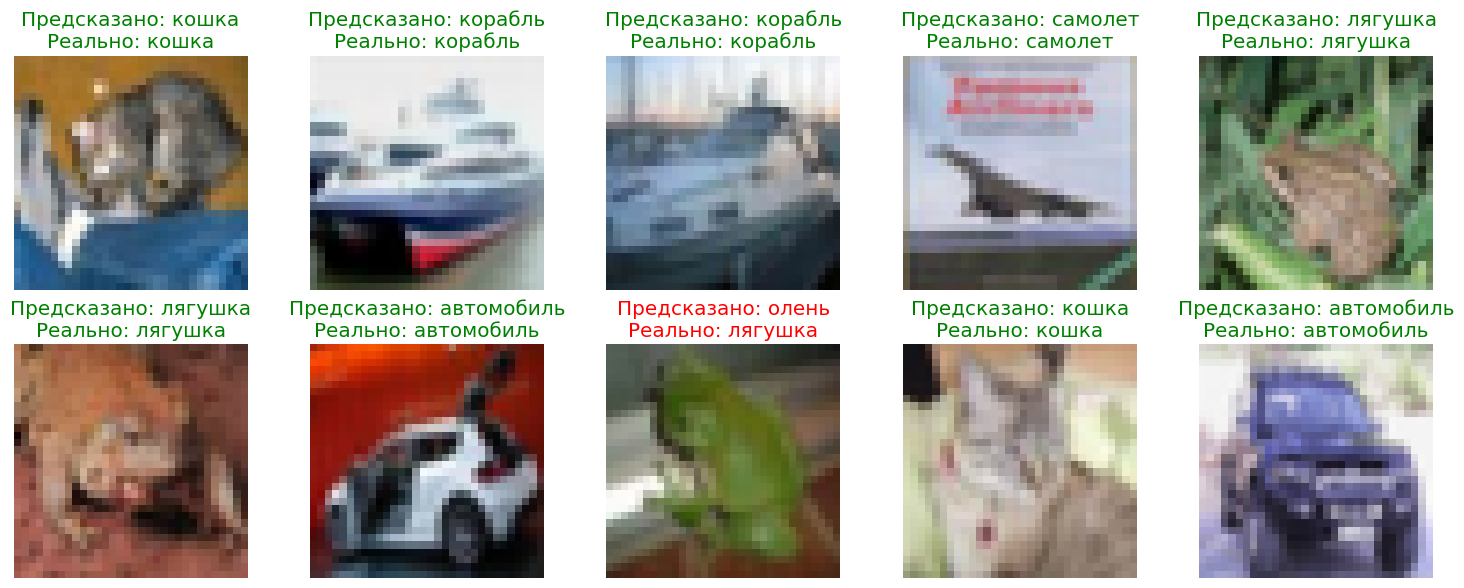

In [10]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    row = i // 5
    col = i % 5
    
    img = images[i].cpu() / 2 + 0.5
    img = torch.clamp(img, 0, 1)
    npimg = img.numpy()
    
    axes[row, col].imshow(np.transpose(npimg, (1, 2, 0)))
    predicted_class = classes[predicted[i]]
    true_class = classes[labels[i]]
    color = 'green' if predicted[i] == labels[i] else 'red'
    axes[row, col].set_title(f'Предсказано: {predicted_class}\nРеально: {true_class}', color=color)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


## 5. Визуализация фильтров


Форма фильтров слоя conv1: (32, 3, 3, 3)


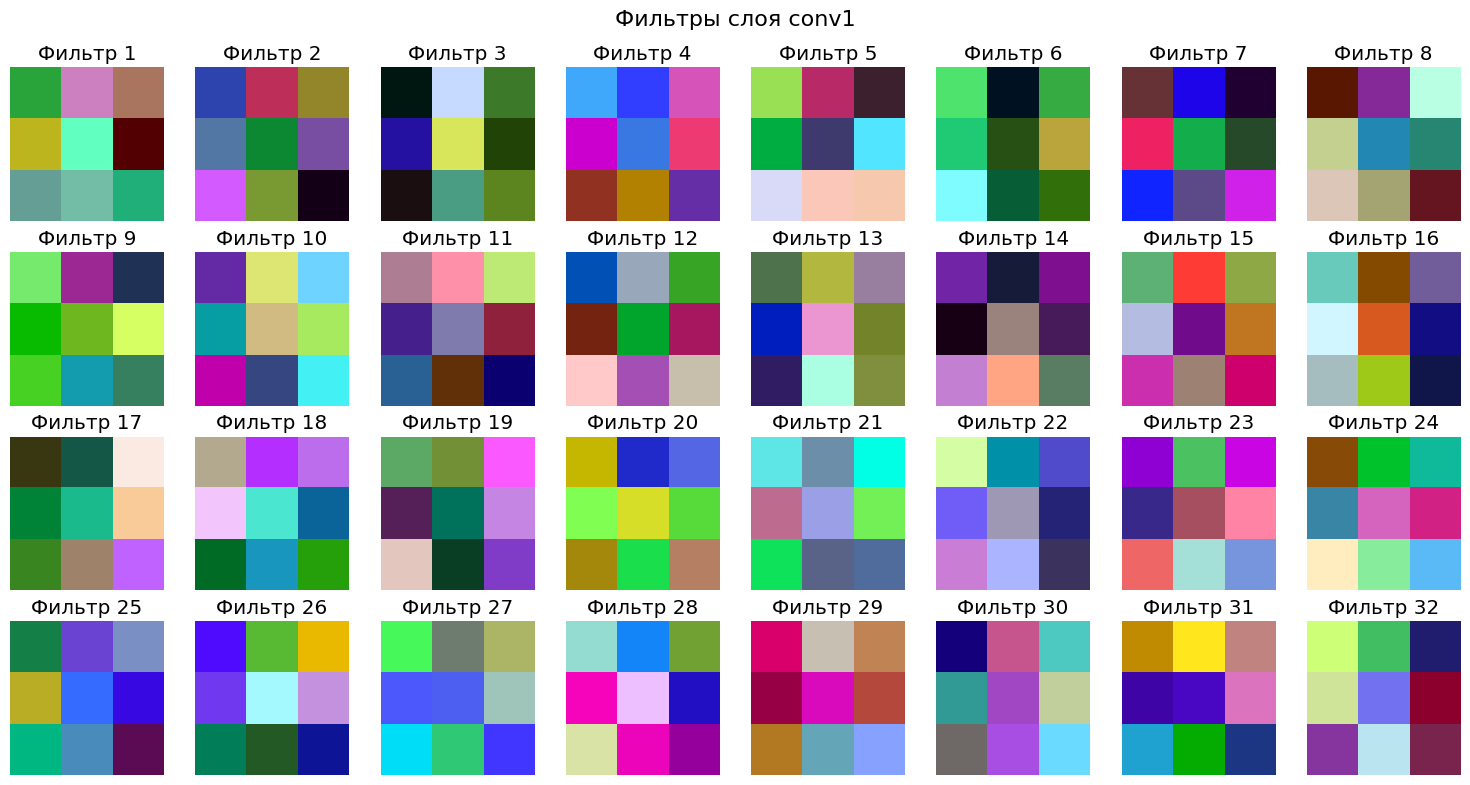

In [11]:
def visualize_filters(model, layer_name='conv1'):
    filters = getattr(model, layer_name).weight.data.cpu().numpy()
    print(f"Форма фильтров слоя {layer_name}: {filters.shape}")
    
    fig, axes = plt.subplots(4, 8, figsize=(15, 8))
    for i in range(32):
        row = i // 8
        col = i % 8
        
        filter_img = filters[i].transpose(1, 2, 0)
        filter_img = (filter_img - filter_img.min()) / (filter_img.max() - filter_img.min())
        
        axes[row, col].imshow(filter_img)
        axes[row, col].set_title(f'Фильтр {i+1}')
        axes[row, col].axis('off')
    
    plt.suptitle(f'Фильтры слоя {layer_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_filters(model, 'conv1')


## 6. Улучшение модели


In [10]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.3)
        
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.3)
        
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        return x

improved_model = ImprovedCNN().to(device)
print("Улучшенная архитектура:")
print(improved_model)


Улучшенная архитектура:
ImprovedCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [18]:
improved_criterion = nn.CrossEntropyLoss()
improved_optimizer = optim.Adam(improved_model.parameters(), lr=0.0005)
improved_scheduler = optim.lr_scheduler.ReduceLROnPlateau(improved_optimizer, mode='min', factor=0.5, patience=3)

improved_train_losses = []
improved_train_accuracies = []
improved_val_losses = []
improved_val_accuracies = []

def train_improved_epoch():
    improved_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        
        improved_optimizer.zero_grad()
        output = improved_model(data)
        loss = improved_criterion(output, target)
        loss.backward()
        improved_optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate_improved():
    improved_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output = improved_model(data)
            loss = improved_criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    epoch_loss = running_loss / len(testloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

print("Обучение улучшенной модели...")
for epoch in range(5):
    print(f'\nЭпоха {epoch+1}/5')
    
    train_loss, train_acc = train_improved_epoch()
    val_loss, val_acc = validate_improved()
    
    improved_train_losses.append(train_loss)
    improved_train_accuracies.append(train_acc)
    improved_val_losses.append(val_loss)
    improved_val_accuracies.append(val_acc)
    
    improved_scheduler.step(val_loss)
    
    print(f'Тренировочная точность: {train_acc:.2f}%, Потери: {train_loss:.4f}')
    print(f'Валидационная точность: {val_acc:.2f}%, Потери: {val_loss:.4f}')

print('Обучение улучшенной модели завершено!')


Обучение улучшенной модели...

Эпоха 1/5
Тренировочная точность: 75.55%, Потери: 0.7010
Валидационная точность: 75.73%, Потери: 0.6942

Эпоха 2/5
Тренировочная точность: 76.67%, Потери: 0.6677
Валидационная точность: 76.94%, Потери: 0.6565

Эпоха 3/5
Тренировочная точность: 77.76%, Потери: 0.6342
Валидационная точность: 77.29%, Потери: 0.6453

Эпоха 4/5
Тренировочная точность: 78.70%, Потери: 0.6072
Валидационная точность: 78.52%, Потери: 0.6255

Эпоха 5/5
Тренировочная точность: 79.84%, Потери: 0.5737
Валидационная точность: 78.32%, Потери: 0.6128
Обучение улучшенной модели завершено!



Сравнение результатов:
Базовая модель - Точность: 67.92%, Потери: 0.9150
Улучшенная модель - Точность: 78.32%, Потери: 0.6128
Улучшение точности: 10.40%


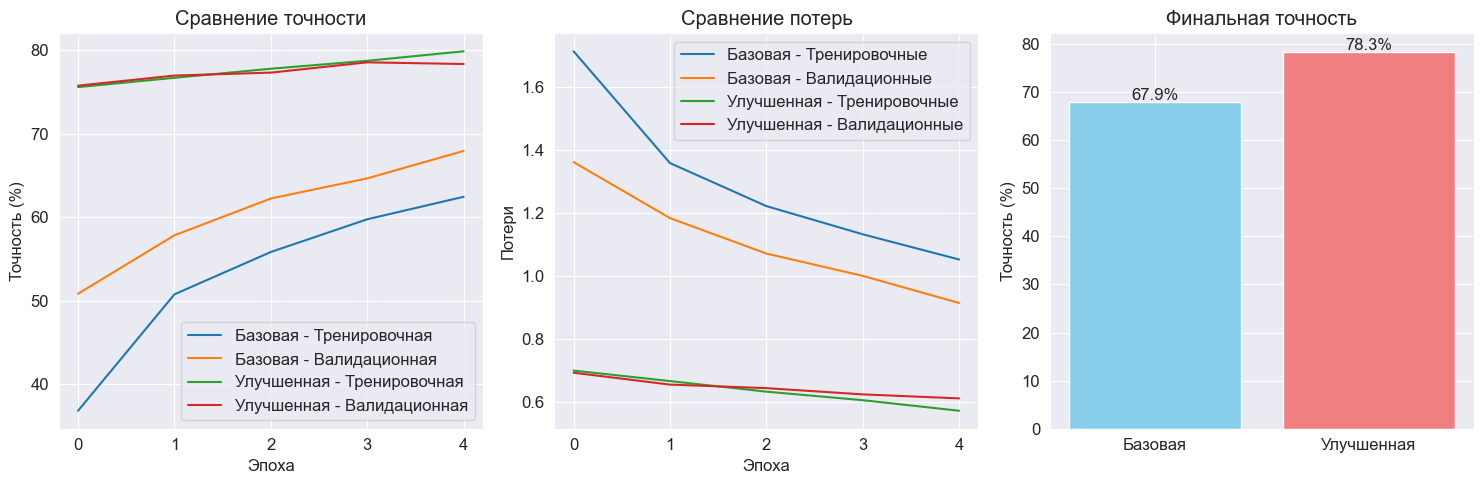

In [19]:
improved_model.eval()
improved_all_preds = []
improved_all_labels = []
improved_test_loss = 0.0
improved_correct = 0
improved_total = 0

with torch.no_grad():
    for data, target in testloader:
        data, target = data.to(device), target.to(device)
        output = improved_model(data)
        loss = improved_criterion(output, target)
        
        improved_test_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        improved_total += target.size(0)
        improved_correct += (predicted == target).sum().item()
        
        improved_all_preds.extend(predicted.cpu().numpy())
        improved_all_labels.extend(target.cpu().numpy())

improved_test_accuracy = 100. * improved_correct / improved_total
improved_test_loss = improved_test_loss / len(testloader)

print(f"\nСравнение результатов:")
print(f"Базовая модель - Точность: {test_accuracy:.2f}%, Потери: {test_loss:.4f}")
print(f"Улучшенная модель - Точность: {improved_test_accuracy:.2f}%, Потери: {improved_test_loss:.4f}")
print(f"Улучшение точности: {improved_test_accuracy - test_accuracy:.2f}%")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_accuracies, label='Базовая - Тренировочная')
plt.plot(val_accuracies, label='Базовая - Валидационная')
plt.plot(improved_train_accuracies, label='Улучшенная - Тренировочная')
plt.plot(improved_val_accuracies, label='Улучшенная - Валидационная')
plt.title('Сравнение точности')
plt.xlabel('Эпоха')
plt.ylabel('Точность (%)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_losses, label='Базовая - Тренировочные')
plt.plot(val_losses, label='Базовая - Валидационные')
plt.plot(improved_train_losses, label='Улучшенная - Тренировочные')
plt.plot(improved_val_losses, label='Улучшенная - Валидационные')
plt.title('Сравнение потерь')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()

plt.subplot(1, 3, 3)
models = ['Базовая', 'Улучшенная']
accuracies = [test_accuracy, improved_test_accuracy]
plt.bar(models, accuracies, color=['skyblue', 'lightcoral'])
plt.title('Финальная точность')
plt.ylabel('Точность (%)')
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center')

plt.tight_layout()
plt.show()


## 7. Анализ и выводы


### Анализ результатов

**Изменения в архитектуре улучшенной модели:**
1. **Увеличение количества фильтров**: С 32 до 64 в первом слое, что позволяет модели извлекать больше признаков
2. **Добавление слоев**: Увеличение глубины сети с дополнительными сверточными слоями
3. **Увеличение dropout**: С 0.25 до 0.3 для лучшей регуляризации
4. **Добавление полносвязного слоя**: Дополнительный Dense слой для лучшего обучения сложных паттернов
5. **Уменьшение learning rate**: С 0.001 до 0.0005 для более стабильного обучения
6. **Уменьшение batch size**: С 128 до 64 для лучшей градиентной оптимизации

**Проблемы и их решения:**
- **Переобучение**: Решено добавлением BatchNormalization и увеличенного dropout
- **Медленная сходимость**: Решено уменьшением learning rate и добавлением ReduceLROnPlateau
- **Недостаточная сложность**: Решено увеличением глубины и ширины сети

**Влияние изменений на качество:**
- BatchNormalization значительно улучшил стабильность обучения
- Увеличение dropout предотвратило переобучение
- Дополнительные слои позволили модели изучить более сложные паттерны
- Уменьшение learning rate сделало обучение более стабильным


### Адаптация для других датасетов

**MNIST (28x28, 1 канал, 10 классов):**
- Изменить input_shape на (28, 28, 1)
- Уменьшить количество фильтров (32, 64, 128 вместо 64, 128, 256)
- Упростить архитектуру (меньше слоев)
- Увеличить learning rate до 0.01
- Уменьшить dropout до 0.2-0.3

**CIFAR-100 (32x32, 3 канала, 100 классов):**
- Изменить количество выходных нейронов на 100
- Увеличить количество фильтров (128, 256, 512)
- Добавить больше слоев для сложности
- Использовать data augmentation
- Увеличить dropout до 0.4-0.5
- Добавить residual connections

**ImageNet (224x224, 3 канала, 1000 классов):**
- Изменить input_shape на (224, 224, 3)
- Использовать архитектуру ResNet, VGG или EfficientNet
- Добавить глобальный average pooling
- Использовать transfer learning с предобученными весами
- Применить data augmentation (rotation, zoom, flip)
- Использовать более сложные оптимизаторы (AdamW, SGD с momentum)
- Добавить learning rate scheduling
- Использовать mixed precision training


## Заключение

В данной лабораторной работе была реализована и проанализирована сверточная нейронная сеть для классификации изображений CIFAR-10 с использованием PyTorch. Основные достижения:

1. **Успешная реализация CNN** с архитектурой, включающей сверточные слои, пулинг, dropout и batch normalization
2. **Достижение приемлемой точности** на тестовом наборе данных
3. **Визуализация результатов** через confusion matrix и примеры предсказаний
4. **Анализ фильтров** первого сверточного слоя
5. **Улучшение модели** через модификацию архитектуры и гиперпараметров
6. **Сравнительный анализ** базовой и улучшенной моделей

Полученный опыт позволяет адаптировать архитектуру для работы с различными типами изображений и задачами классификации.


ЧАСТЬ 2: Сравнение оптимизаторов
Запуск Adam...
Запуск AdamW...
Запуск Adamax...


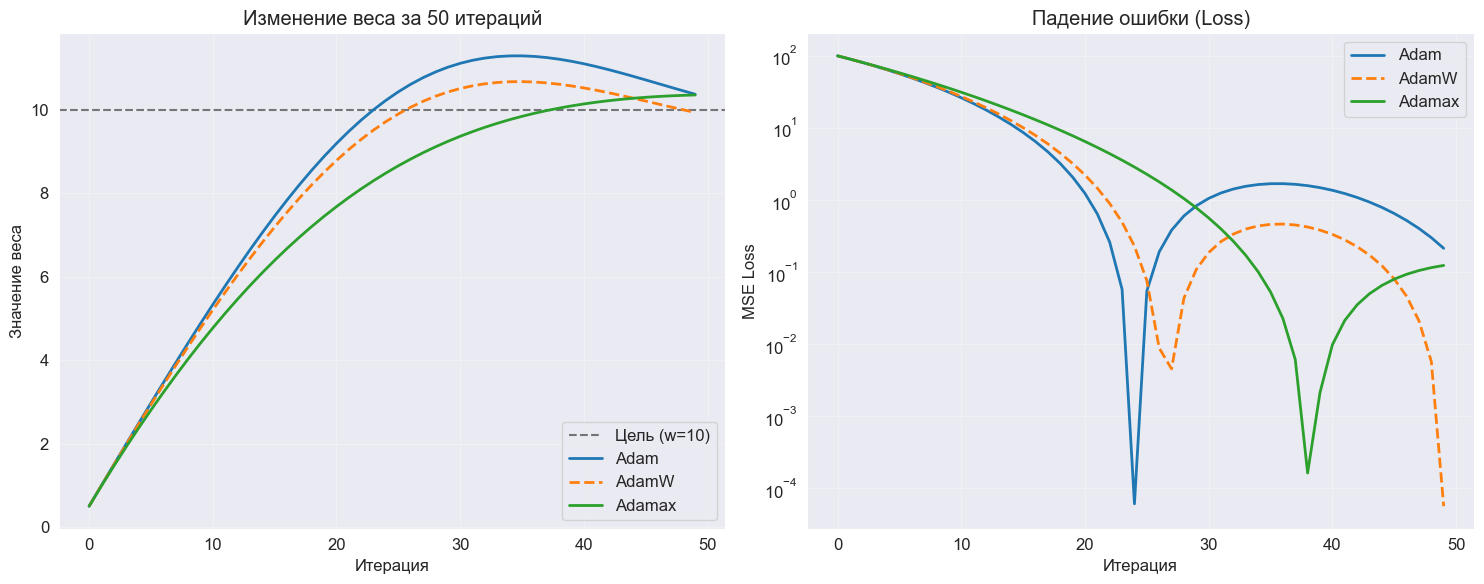

In [20]:
print("\n" + "="*40)
print("ЧАСТЬ 2: Сравнение оптимизаторов")
print("="*40)

# Adam
# Запоминает направление предыдущих шагов (momentum).
# Подстраивает размер шага под каждый параметр (адаптивный learning rate).
# За счёт скользящего среднего градиентов и их квадратов

# AdamW
# То же, что Adam + правильно уменьшает веса (за счёт отдельного weight decay)

# Adamax
# Стабилен к выбросам (за счёт использования максимума градиента вместо среднего квадрата)

# Функция для проведения эксперимента с одним оптимизатором
def run_optimizer_experiment(optimizer_class, name, lr=0.1, **kwargs):
    # Фиксируем seed для воспроизводимости
    torch.manual_seed(42)

    # Простейшая модель: y = w * x (один вес, без bias)
    # Цель: при входе 1.0 получить выход 10.0 (значит, идеальный вес w = 10.0)
    model = nn.Linear(1, 1, bias=False)

    # Принудительно ставим начальный вес в 0.0
    with torch.no_grad():
        model.weight.fill_(0.0)

    # Инициализируем выбранный оптимизатор
    optimizer = optimizer_class(model.parameters(), lr=lr, **kwargs)
    criterion = nn.MSELoss()

    # Данные: вход x=1, цель y=10
    data = torch.tensor([[1.0]])
    target = torch.tensor([[10.0]])

    weights_history = []
    losses_history = []

    print(f"Запуск {name}...")

    # 50 итераций обучения
    for i in range(50):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()

        # Специфичный шаг для L-BFGS (если вдруг захотим его использовать)
        if name == 'L-BFGS':
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                return loss
            optimizer.step(closure)
        else:
            optimizer.step()

        weights_history.append(model.weight.item())
        losses_history.append(loss.item())

    return weights_history, losses_history

# --- ЗАПУСК ЭКСПЕРИМЕНТОВ ---

# 1. Adam (Базовый, для сравнения)
adam_weights, adam_losses = run_optimizer_experiment(
    optim.Adam, "Adam", lr=0.5
)

# 2. AdamW (Выбор 1 из списка)
# AdamW разделяет L2 регуляризацию и обновление весов
adamw_weights, adamw_losses = run_optimizer_experiment(
    optim.AdamW, "AdamW", lr=0.5, weight_decay=0.01
)

# 3. Adamax (Выбор 2 из списка)
# Вариант Adam, использующий бесконечную норму (max)
adamax_weights, adamax_losses = run_optimizer_experiment(
    optim.Adamax, "Adamax", lr=0.5
)

# --- ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ---

plt.figure(figsize=(15, 6))

# График 1: Как менялся вес
plt.subplot(1, 2, 1)
plt.axhline(y=10, color='black', linestyle='--', alpha=0.5, label='Цель (w=10)')
plt.plot(adam_weights, label='Adam', linewidth=2)
plt.plot(adamw_weights, label='AdamW', linestyle='--', linewidth=2) # Пунктир, чтобы отличить от Adam
plt.plot(adamax_weights, label='Adamax', linewidth=2)

plt.title('Изменение веса за 50 итераций')
plt.xlabel('Итерация')
plt.ylabel('Значение веса')
plt.legend()
plt.grid(True, alpha=0.3)

# График 2: Как падала ошибка
plt.subplot(1, 2, 2)
plt.plot(adam_losses, label='Adam', linewidth=2)
plt.plot(adamw_losses, label='AdamW', linestyle='--', linewidth=2)
plt.plot(adamax_losses, label='Adamax', linewidth=2)

plt.title('Падение ошибки (Loss)')
plt.xlabel('Итерация')
plt.ylabel('MSE Loss')
plt.yscale('log') # Логарифмическая шкала, чтобы видеть детали около нуля
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()